This script makes a route geojson file

In [ ]:
!pip install osmnx 
!pip install geopandas
!pip install networkx
!pip install pygeos

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from shapely.geometry import LineString
import requests
import json
gpd.options.use_pygeos = True

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
scoredEdges = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/finalScoredEdges.csv')

In [6]:
#convert string to shapely linestring
scoredEdges['geometry'] = scoredEdges['geometry'].apply(wkt.loads)

#convert edges to gdf
scoredEdges_gdf = gpd.GeoDataFrame(scoredEdges, crs='EPSG:4326', geometry=scoredEdges['geometry'])

In [7]:
#clean edge data and set appropriate index
scoredEdges_gdf = scoredEdges_gdf.drop(columns=['Unnamed: 0', 'index'])
scoredEdges_gdf = scoredEdges_gdf.set_index(['u', 'v', 'key'])
scoredEdges_gdf

osmid  oneway lanes  \
u          v          key                                                    
199732     2447309494 0                             29065909    True     3   
           4683383695 0                             11000070   False   NaN   
           318697385  0                             25535788   False     3   
199735     8946359241 0                              4997667    True   NaN   
           33183691   0                             25498425    True     2   
...                                                      ...     ...   ...   
9785527823 1350779145 0                            120473161   False   NaN   
           1350779051 0                            120473161   False   NaN   
           1442012761 0    [130986624, 130986625, 130986627]   False   NaN   
9785877175 497942122  0                           1065575065   False   NaN   
           497942246  0                             40904413    True   NaN   

                                       name               highway maxspeed  \
u          v          key                                                    
199732     2447309494 0    Universitätsring             secondary       50   
           4683383695 0                 NaN              cycleway      NaN   
           318697385  0        Rathausplatz              tertiary       50   
199735     8946359241 0     Schmerlingplatz              tertiary       30   
           33183691   0     Auerspergstraße             secondary       50   
...                                     ...                   ...      ...   
9785527823 1350779145 0           Bermenweg               footway      NaN   
           1350779051 0           Bermenweg               footway      NaN   
           1442012761 0                 NaN  ['footway', 'steps']      NaN   
9785877175 497942122  0                 NaN               service      NaN   
           497942246  0                 NaN               service      NaN   

                                                surface  lit   length  \
u          v          key                                               
199732     2447309494 0                         asphalt  yes   11.008   
           4683383695 0                         asphalt  yes   14.358   
           318697385  0                         asphalt  yes   20.372   
199735     8946359241 0                         asphalt  yes    3.473   
           33183691   0                         asphalt  yes   16.389   
...                                                 ...  ...      ...   
9785527823 1350779145 0                         asphalt   no   21.841   
           1350779051 0                         asphalt   no  153.281   
           1442012761 0    ['asphalt', 'paving_stones']  yes   16.282   
9785877175 497942122  0                              no   no    8.526   
           497942246  0                              no   no   22.029   

                                                                    geometry  \
u          v          key                                                      
199732     2447309494 0    LINESTRING (16.36014 48.20866, 16.36016 48.20876)   
           4683383695 0    LINESTRING (16.36014 48.20866, 16.36019 48.208...   
           318697385  0    LINESTRING (16.36014 48.20866, 16.36005 48.208...   
199735     8946359241 0    LINESTRING (16.35586 48.20684, 16.35590 48.20685)   
           33183691   0    LINESTRING (16.35586 48.20684, 16.35582 48.206...   
...                                                                      ...   
9785527823 1350779145 0    LINESTRING (16.41860 48.18545, 16.41855 48.185...   
           1350779051 0    LINESTRING (16.41860 48.18545, 16.41872 48.185...   
           1442012761 0    LINESTRING (16.41860 48.18545, 16.41862 48.185...   
9785877175 497942122  0    LINESTRING (16.36991 48.19656, 16.36985 48.19662)   
           497942246  0    LINESTRING (16.36991 48.19656, 16.36992 48.196...   

                           ... saf

In [8]:
#get windspeed and direction

MY_API_KEY = "4561471e50msh3d1e762ef5340e0p12521djsn5f37f41058cd"

url = "https://community-open-weather-map.p.rapidapi.com/weather"

querystring = {"q":"Vienna, Austria","lat":"0","lon":"0","callback":"","id":"2172797","lang":"null","units":"metric"}

headers = {
	"X-RapidAPI-Host": "community-open-weather-map.p.rapidapi.com",
	"X-RapidAPI-Key": "4561471e50msh3d1e762ef5340e0p12521djsn5f37f41058cd"
}

response = requests.request("GET", url, headers=headers, params=querystring)

#convert response to json
data = json.loads(response.text)

#parse json for relevent data
windDirection = data['wind']['deg']
windSpeed = data['wind']['speed']
print(windDirection, windSpeed)


312 9.83


In [9]:
#check which wind column direction to use
if windDirection > 337.5 and windDirection < 22.5:
  wCol = 'w1'
elif windDirection > 22.5 and windDirection < 67.5:
  wCol = 'w2'
elif windDirection > 67.5 and windDirection < 112.5:
  wCol = 'w3'
elif windDirection > 112.5 and windDirection < 157.5:
  wCol = 'w4'
elif windDirection > 157.5 and windDirection < 202.5:
  wCol = 'w5'
elif windDirection > 202.5 and windDirection < 247.5:
  wCol = 'w6'
elif windDirection > 247.5 and windDirection < 292.5:
  wCol = 'w7'
else:
  wCol = 'w8'
wCol

#create wind scores
windSpeedList = scoredEdges[wCol]*windSpeed
windScore = []
for i in range(len(windSpeedList)):
  if windSpeedList[i] < 1.8:
    windScore.append(0)
  elif windSpeedList[i] > 1.8 and windSpeedList[i] < 3.6:
    windScore.append(0.25)
  elif windSpeedList[i] > 3.6 and windSpeedList[i] < 5.3:
    windScore.append(0.50)
  elif windSpeedList[i] > 5.3 and windSpeedList[i] < 7.6:
    windScore.append(0.75)
  elif windSpeedList[i] > 7.6:
    windScore.append(1)
  else: 
    windScore.append(0.25)

In [10]:
scoredEdges_gdf['windScore'] = windScore

In [11]:
#preferences:  0, 1 to 5,  0: don't include in weight, 1: weight the most, 5: weight the least
bikePref = 5
litPref = 0
surfacePref = 5
vegPref = 0
windPref = 0
lengthPref = 5

#create windScore
np.array(windPref*scoredEdges[wCol]*windSpeed)

combinedScore = np.array(bikePref*scoredEdges['safetyScore']) + np.array(litPref*scoredEdges['litScore']) + np.array(surfacePref*scoredEdges['pavedScore']) + np.array(lengthPref*scoredEdges['lengthMod']) + np.array(vegPref*scoredEdges['vegScore'] + np.array(windPref*scoredEdges_gdf['windScore']))
scoredEdges_gdf['combinedScore'] = combinedScore

In [12]:
nodes_df = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/nodes.csv')

In [13]:
nodes_df

,osmid,y,x,highway,street_count,ref,geometry
0,199732,48.208662,16.360136,traffic_signals,4,NaN,POINT (16.3601365 48.2086619)
1,199735,48.206836,16.355856,traffic_signals,4,NaN,POINT (16.3558556 48.2068359)
2,199736,48.207697,16.355375,NaN,3,NaN,POINT (16.3553748 48.2076973)
3,199739,48.214093,16.359259,NaN,3,NaN,POINT (16.3592592 48.2140926)
4,199740,48.214422,16.358265,NaN,4,NaN,POINT (16.3582651 48.214422)
...,...,...,...,...,...,...,...
56629,9792195680,48.244985,16.368995,NaN,3,NaN,POINT (16.3689951 48.2449851)
56630,9793858702,48.197753,16.305677,NaN,3,NaN,POINT (16.3056768 48.1977534)
56631,9793858703,48.198452,16.306842,NaN,3,NaN,POINT (16.306842 48.1984517)
56632,9793858704,48.198686,16.307022,NaN,3,NaN,POINT (16.3070219 48.1986864)


In [14]:
#convert node csv to df to gdf
node_df = pd.DataFrame(
    {'y': list(nodes_df['y']),
     'x': list(nodes_df['x'])})

node_gdf = gpd.GeoDataFrame(node_df, geometry=gpd.points_from_xy(node_df.x, node_df.y))
node_gdf['osmid'] = list(nodes_df['osmid'])
node_gdf = node_gdf.set_index('osmid')
node_gdf

,y,x,geometry
osmid,,,
199732,48.208662,16.360136,POINT (16.36014 48.20866)
199735,48.206836,16.355856,POINT (16.35586 48.20684)
199736,48.207697,16.355375,POINT (16.35537 48.20770)
199739,48.214093,16.359259,POINT (16.35926 48.21409)
199740,48.214422,16.358265,POINT (16.35827 48.21442)
...,...,...,...
9792195680,48.244985,16.368995,POINT (16.36900 48.24499)
9793858702,48.197753,16.305677,POINT (16.30568 48.19775)
9793858703,48.198452,16.306842,POINT (16.30684 48.19845)


In [15]:
scoredEdges_gdf

osmid  oneway lanes  \
u          v          key                                                    
199732     2447309494 0                             29065909    True     3   
           4683383695 0                             11000070   False   NaN   
           318697385  0                             25535788   False     3   
199735     8946359241 0                              4997667    True   NaN   
           33183691   0                             25498425    True     2   
...                                                      ...     ...   ...   
9785527823 1350779145 0                            120473161   False   NaN   
           1350779051 0                            120473161   False   NaN   
           1442012761 0    [130986624, 130986625, 130986627]   False   NaN   
9785877175 497942122  0                           1065575065   False   NaN   
           497942246  0                             40904413    True   NaN   

                                       name               highway maxspeed  \
u          v          key                                                    
199732     2447309494 0    Universitätsring             secondary       50   
           4683383695 0                 NaN              cycleway      NaN   
           318697385  0        Rathausplatz              tertiary       50   
199735     8946359241 0     Schmerlingplatz              tertiary       30   
           33183691   0     Auerspergstraße             secondary       50   
...                                     ...                   ...      ...   
9785527823 1350779145 0           Bermenweg               footway      NaN   
           1350779051 0           Bermenweg               footway      NaN   
           1442012761 0                 NaN  ['footway', 'steps']      NaN   
9785877175 497942122  0                 NaN               service      NaN   
           497942246  0                 NaN               service      NaN   

                                                surface  lit   length  \
u          v          key                                               
199732     2447309494 0                         asphalt  yes   11.008   
           4683383695 0                         asphalt  yes   14.358   
           318697385  0                         asphalt  yes   20.372   
199735     8946359241 0                         asphalt  yes    3.473   
           33183691   0                         asphalt  yes   16.389   
...                                                 ...  ...      ...   
9785527823 1350779145 0                         asphalt   no   21.841   
           1350779051 0                         asphalt   no  153.281   
           1442012761 0    ['asphalt', 'paving_stones']  yes   16.282   
9785877175 497942122  0                              no   no    8.526   
           497942246  0                              no   no   22.029   

                                                                    geometry  \
u          v          key                                                      
199732     2447309494 0    LINESTRING (16.36014 48.20866, 16.36016 48.20876)   
           4683383695 0    LINESTRING (16.36014 48.20866, 16.36019 48.208...   
           318697385  0    LINESTRING (16.36014 48.20866, 16.36005 48.208...   
199735     8946359241 0    LINESTRING (16.35586 48.20684, 16.35590 48.20685)   
           33183691   0    LINESTRING (16.35586 48.20684, 16.35582 48.206...   
...                                                                      ...   
9785527823 1350779145 0    LINESTRING (16.41860 48.18545, 16.41855 48.185...   
           1350779051 0    LINESTRING (16.41860 48.18545, 16.41872 48.185...   
           1442012761 0    LINESTRING (16.41860 48.18545, 16.41862 48.185...   
9785877175 497942122  0    LINESTRING (16.36991 48.19656, 16.36985 48.19662)   
           497942246  0    LINESTRING (16.36991 48.19656, 16.36992 48.196...   

                           ...    

In [16]:
G_weighted = ox.graph_from_gdfs(node_gdf, scoredEdges_gdf)

In [17]:
#Find node closest to start and end points (NEED TO REWRITE THIS USING SINDEX NEAREST)
# Source
source_address = "Schönbrunn Palace, Austria"
source_location= ox.geocode(source_address)  # notice the coordinate order (y, x)
source_point = Point(source_location[1], source_location[0])

# Target
target_address = "Laufbergergasse 12, 1020 Wien, Austria"
target_location = ox.geocode(target_address) 
target_point = Point(target_location[1], target_location[0])

#Get index of nearest nodes in the graph for the source and target locations
source_index = node_gdf.sindex.nearest(source_point, return_all=False)
target_index = node_gdf.sindex.nearest(target_point, return_all=False)

#get osmid of nearest node
source_node = list(node_gdf.iloc[[source_index[1][0]]].index)[0]
target_node = list(node_gdf.iloc[[target_index[1][0]]].index)[0]

In [18]:
#shortest route
route = ox.distance.shortest_path(G_weighted, source_node, target_node, weight = 'combinedScore')

In [19]:
#route node osmid to geometry to json
lat_list = list(node_gdf.loc[route].x)
long_list = list(node_gdf.loc[route].y)

route_geom = LineString(zip(lat_list, long_list))
gpd.GeoSeries([route_geom]).to_file('route_json.geojson', driver='GeoJSON')

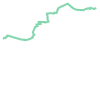

In [20]:
route_geom

In [26]:
features = gpd.GeoSeries([route_geom]).to_json()

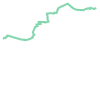

In [30]:
route_geom

In [27]:
features

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "LineString", "coordinates": [[16.3113632, 48.1848184], [16.3109529, 48.1849165], [16.3107453, 48.1851737], [16.3108594, 48.1853831], [16.3109274, 48.185508], [16.3112921, 48.1856522], [16.3125328, 48.1853522], [16.313214, 48.1866313], [16.3133162, 48.1868202], [16.3136042, 48.1867495], [16.3136465, 48.1868539], [16.313666, 48.1870416], [16.3139325, 48.1869815], [16.314015, 48.1869626], [16.3143971, 48.1876658], [16.3146547, 48.1876816], [16.3151318, 48.1875376], [16.3158265, 48.1873278], [16.3164134, 48.1871506], [16.3200527, 48.1860555], [16.320047, 48.1860038], [16.3201111, 48.185988], [16.3203319, 48.1859337], [16.3204211, 48.1859131], [16.3204416, 48.185952], [16.3263967, 48.1841633], [16.3274408, 48.1839732], [16.3275106, 48.183957], [16.3292705, 48.1839228], [16.3293633, 48.1838635], [16.3295516, 48.1838907], [16.3296555, 48.1838946], [16.329695, 48.18353], [16.32990

In [ ]:
#print route characteristics
routeType = route

lengthBike = 0
lengthPaved = 0
lengthLit = 0
length = 0
lengthVeg = 0
lengthWindCalm = 0

for i in range(len(routeType)-1):
  length += G_weighted[routeType[i]][routeType[i+1]][0]['length']
  if G_weighted[routeType[i]][routeType[i+1]][0]['highway'] == 'cycleway':
    lengthBike += G_weighted[routeType[i]][routeType[i+1]][0]['length']
  if G_weighted[routeType[i]][routeType[i+1]][0]['surface'] == 'concrete' or G_weighted[routeType[i]][routeType[i+1]][0]['surface'] == 'asphalt':
    lengthPaved += G_weighted[routeType[i]][routeType[i+1]][0]['length']
  if G_weighted[routeType[i]][routeType[i+1]][0]['lit'] == 'yes':
    lengthLit += G_weighted[routeType[i]][routeType[i+1]][0]['length']
  if G_weighted[routeType[i]][routeType[i+1]][0]['vegScore'] > 0.5:
    lengthVeg += G_weighted[routeType[i]][routeType[i+1]][0]['length']
  if G_weighted[routeType[i]][routeType[i+1]][0]['windScore'] < 0.50:
    lengthWindCalm += G_weighted[routeType[i]][routeType[i+1]][0]['length']

print('% Lit: ' + str(round((lengthLit*100/length), 2)) + 
      '\n% Paved: '+ str(round((lengthPaved*100/length), 2)) + 
      '\n% Bike Lane: '+ str(round((lengthBike*100/length), 2)) + 
      '\n% of route with moderate to high amounts of veg: '+ str(round((lengthVeg*100/length), 2)) +
      '\n% Calm Wind: '+ str(round((lengthWindCalm*100/length), 2)) + 
      '\nTotal Length: '+ str(round((length), 2)))


% Lit: 94.88
% Paved: 87.44
% Bike Lane: 58.25
% of route with moderate to high amounts of veg: 31.24
% Calm Wind: 100.0
Total Length: 11005.61


# Interactive Wind

In [ ]:
scoredEdges = pd.read_csv('/content/drive/MyDrive/S0_STUDIO/AIA_Studio/Data/finalScoredEdges.csv')

In [ ]:
#get windspeed and direction

MY_API_KEY = "4561471e50msh3d1e762ef5340e0p12521djsn5f37f41058cd"

url = "https://community-open-weather-map.p.rapidapi.com/weather"

querystring = {"q":"Vienna, Austria","lat":"0","lon":"0","callback":"","id":"2172797","lang":"null","units":"metric"}

headers = {
	"X-RapidAPI-Host": "community-open-weather-map.p.rapidapi.com",
	"X-RapidAPI-Key": "4561471e50msh3d1e762ef5340e0p12521djsn5f37f41058cd"
}

response = requests.request("GET", url, headers=headers, params=querystring)

#convert response to json
data = json.loads(response.text)

#parse json for relevent data
windDirection = data['wind']['deg']
windSpeed = data['wind']['speed']
print(windDirection, windSpeed)


100 1.54


In [ ]:
#check which wind column direction to use
if windDirection > 337.5 and windDirection < 22.5:
  wCol = 'w1'
elif windDirection > 22.5 and windDirection < 67.5:
  wCol = 'w2'
elif windDirection > 67.5 and windDirection < 112.5:
  wCol = 'w3'
elif windDirection > 112.5 and windDirection < 157.5:
  wCol = 'w4'
elif windDirection > 157.5 and windDirection < 202.5:
  wCol = 'w5'
elif windDirection > 202.5 and windDirection < 247.5:
  wCol = 'w6'
elif windDirection > 247.5 and windDirection < 292.5:
  wCol = 'w7'
else:
  wCol = 'w8'
wCol

'w3'

In [ ]:
windEdges = scoredEdges[['geometry', wCol]]
windSpeed_list = windEdges[wCol]*windSpeed

#assign colors
wColor = []
for i in range(len(windSpeed_list)):
  if windSpeed_list[i] < 0.5:
    wColor.append('FFFFF')
  elif windSpeed_list[i] > 0.5 and windSpeed_list[i] <= 1.0 :
    wColor.append('CFF8FF')
  elif windSpeed_list[i] > 1 and windSpeed_list[i] <= 2 :
    wColor.append('37DFFF')
  elif windSpeed_list[i] > 2 and windSpeed_list[i] <= 3:
    wColor.append('22B4CE')
  elif windSpeed_list[i] > 3 and windSpeed_list[i] <= 4:
    wColor.append('027C93')
  elif windSpeed_list[i] > 4 and windSpeed_list[i] <= 5 :
    wColor.append('0C505E')
  else : 
    wColor.append('03323E')


windEdges[wCol] = windSpeed_list
windEdges['color'] = wColor
windEdges

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,geometry,w3,color
0,"LINESTRING (16.3601365 48.2086619, 16.3601647 ...",0.525283,CFF8FF
1,"LINESTRING (16.3601365 48.2086619, 16.3601852 ...",0.511491,CFF8FF
2,"LINESTRING (16.3601365 48.2086619, 16.3600511 ...",0.508046,CFF8FF
3,"LINESTRING (16.3558556 48.2068359, 16.355898 4...",0.380237,FFFFF
4,"LINESTRING (16.3558556 48.2068359, 16.3558166 ...",0.251935,FFFFF
...,...,...,...
150810,"LINESTRING (16.4186023 48.1854515, 16.4185531 ...",NaN,03323E
150811,"LINESTRING (16.4186023 48.1854515, 16.4187221 ...",NaN,03323E
150812,"LINESTRING (16.4186023 48.1854515, 16.418624 4...",NaN,03323E
150813,"LINESTRING (16.3699085 48.1965569, 16.3698542 ...",NaN,03323E


In [ ]:
#convert string to shapely linestring
windEdges['geometry'] = windEdges['geometry'].apply(wkt.loads)

#convert edges to gdf
windEdges_gdf = gpd.GeoDataFrame(windEdges, crs='EPSG:4326', geometry=windEdges['geometry'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
windEdges_gdf.to_file('windEdges.geojson', driver='GeoJSON')  

# pip freeze

In [ ]:
import session_info
session_info.show()